CLASSIFICATION TASK

Objective: Predict whether a person is likely to seek mental health treatment (treatment column: yes/no)

Importing Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score

import warnings
warnings.filterwarnings('ignore')


Loading the dataframe built in EDA:

In [2]:
df= joblib.load("../Models & Dataset/df.pkl")
print(df.shape)
print(df.columns)
df.head()


(931, 23)
Index(['Age', 'Gender', 'Country', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'company_size'],
      dtype='object')


,Age,Gender,Country,family_history,treatment,work_interfere,no_employees,remote_work,benefits,care_options,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,company_size
0,37,Female,United States,No,Yes,Often,Small,No,Yes,Not sure,...,Easy,No,No,Yes,Yes,No,Maybe,Yes,No,1
2,32,Male,Canada,No,No,Rarely,Small,No,No,No,...,Difficult,No,No,Yes,Yes,Yes,Yes,No,No,1
3,31,Male,United Kingdom,Yes,Yes,Often,Medium,No,No,Yes,...,Difficult,Yes,Yes,Yes,No,Maybe,Maybe,No,Yes,2
4,31,Male,United States,No,No,Never,Medium,Yes,Yes,No,...,Don't know,No,No,Yes,Yes,Yes,Yes,Don't know,No,2
5,33,Male,United States,Yes,No,Sometimes,Small,No,Yes,Not sure,...,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,1


Defining important Features and Target variable:

In [3]:
X= df.drop(columns=['Country','phys_health_consequence','mental_health_interview','phys_health_interview','mental_vs_physical', 'treatment'])
y= df['treatment']
y= y.map({'Yes': 1, 'No': 0})


X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Separating numerical and categorical columns
num_col=['Age', 'company_size']
categ_col= ['Gender','family_history','work_interfere', 'no_employees', 'remote_work', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence','coworkers','supervisor','obs_consequence']

Preprocessing:

In [5]:
preprocessor_standard= ColumnTransformer([("num", StandardScaler(), num_col), ("categ", OneHotEncoder(handle_unknown='ignore'), categ_col)])

preprocessor_tree= ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), categ_col)])


Parameter grids of Models:

In [6]:
param_grids={
    "Logistic Regression": {
        "classifier__C": [0.01, 0.1, 1, 10],
        "classifier__solver": ['lbfgs'],
        "classifier__penalty": ['l2']
    },
    "Random Forest": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__max_depth": [None, 5, 10],
        "classifier__max_features": ['sqrt', 'log2']
    },
    "SVM": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf'],
        "classifier__gamma": ['scale', 'auto']
    },
    "KNN": {
        "classifier__n_neighbors": [3,5,7],
        "classifier__weights": ['uniform', 'distance'],
        "classifier__p": [1, 2]
    }
}

Training & Evaluating Models:

Logistic Regression:

In [7]:
model_probs={}

pipe_lr= Pipeline([("preprocess", preprocessor_standard), ("classifier", LogisticRegression(max_iter=500, random_state=42))])
grid_lr= GridSearchCV(pipe_lr, param_grids["Logistic Regression"], cv=5, scoring= 'roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

y_pred_lr= grid_lr.predict(X_test)
y_proba_lr= grid_lr.predict_proba(X_test)[:,1]

print("                 Logistic Regression")
print("Best Parameters: ", grid_lr.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("Confusion matrix \n" , confusion_matrix(y_test, y_pred_lr))
print("Classification Report: \n ", classification_report(y_test, y_pred_lr))

model_probs["Logistic Regression"]= y_proba_lr

                 Logistic Regression
Best Parameters:  {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Accuracy: 0.839572192513369
ROC-AUC: 0.8811835413777163
Confusion matrix 
 [[64 20]
 [10 93]]
Classification Report: 
                precision    recall  f1-score   support

           0       0.86      0.76      0.81        84
           1       0.82      0.90      0.86       103

    accuracy                           0.84       187
   macro avg       0.84      0.83      0.84       187
weighted avg       0.84      0.84      0.84       187



Random Forest:

In [8]:
pipe_rf = Pipeline([("preprocess", preprocessor_tree), ("classifier", RandomForestClassifier(random_state=42))])
grid_rf = GridSearchCV(pipe_rf, param_grids["Random Forest"], cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

y_pred_rf = grid_rf.predict(X_test)
y_proba_rf = grid_rf.predict_proba(X_test)[:, 1]

print("                 Random Forest")
print("Best Params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion matrix \n" , confusion_matrix(y_test, y_pred_rf))
print("Classification Report: \n ",classification_report(y_test, y_pred_rf))

model_probs["Random Forest"] = y_proba_rf


                 Random Forest
Best Params: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}
Accuracy: 0.8288770053475936
ROC-AUC: 0.8839574664817383
Confusion matrix 
 [[64 20]
 [12 91]]
Classification Report: 
                precision    recall  f1-score   support

           0       0.84      0.76      0.80        84
           1       0.82      0.88      0.85       103

    accuracy                           0.83       187
   macro avg       0.83      0.82      0.83       187
weighted avg       0.83      0.83      0.83       187



SVM:

In [9]:
pipe_svm = Pipeline([("preprocess", preprocessor_standard), ("classifier", SVC(probability=True, random_state=42))])
grid_svm = GridSearchCV(pipe_svm, param_grids["SVM"], cv=5, scoring='roc_auc', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

y_pred_svm = grid_svm.predict(X_test)
y_proba_svm = grid_svm.predict_proba(X_test)[:, 1]

print("                            SVM")
print("Best Params:", grid_svm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_svm))
print("Confusion matrix \n" , confusion_matrix(y_test, y_pred_svm))
print("Classification Report: \n ", classification_report(y_test, y_pred_svm))

model_probs["SVM"] = y_proba_svm

                            SVM
Best Params: {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Accuracy: 0.8181818181818182
ROC-AUC: 0.8601479426722145
Confusion matrix 
 [[57 27]
 [ 7 96]]
Classification Report: 
                precision    recall  f1-score   support

           0       0.89      0.68      0.77        84
           1       0.78      0.93      0.85       103

    accuracy                           0.82       187
   macro avg       0.84      0.81      0.81       187
weighted avg       0.83      0.82      0.81       187



KNN:

In [10]:
pipe_knn = Pipeline([("preprocess", preprocessor_standard), ("classifier", KNeighborsClassifier())])
grid_knn = GridSearchCV(pipe_knn, param_grids["KNN"], cv=5, scoring='roc_auc', n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

y_pred_knn = grid_knn.predict(X_test)
y_proba_knn = grid_knn.predict_proba(X_test)[:, 1]

print("                         KNN")
print("Best Params:", grid_knn.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_knn))

print("Confusion matrix \n" , confusion_matrix(y_test, y_pred_knn))
print("Classification Report: \n ", classification_report(y_test, y_pred_knn))

model_probs["KNN"] = y_proba_knn


                         KNN
Best Params: {'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'distance'}
Accuracy: 0.7433155080213903
ROC-AUC: 0.8040915395284327
Confusion matrix 
 [[65 19]
 [29 74]]
Classification Report: 
                precision    recall  f1-score   support

           0       0.69      0.77      0.73        84
           1       0.80      0.72      0.76       103

    accuracy                           0.74       187
   macro avg       0.74      0.75      0.74       187
weighted avg       0.75      0.74      0.74       187



Comparison of the models:

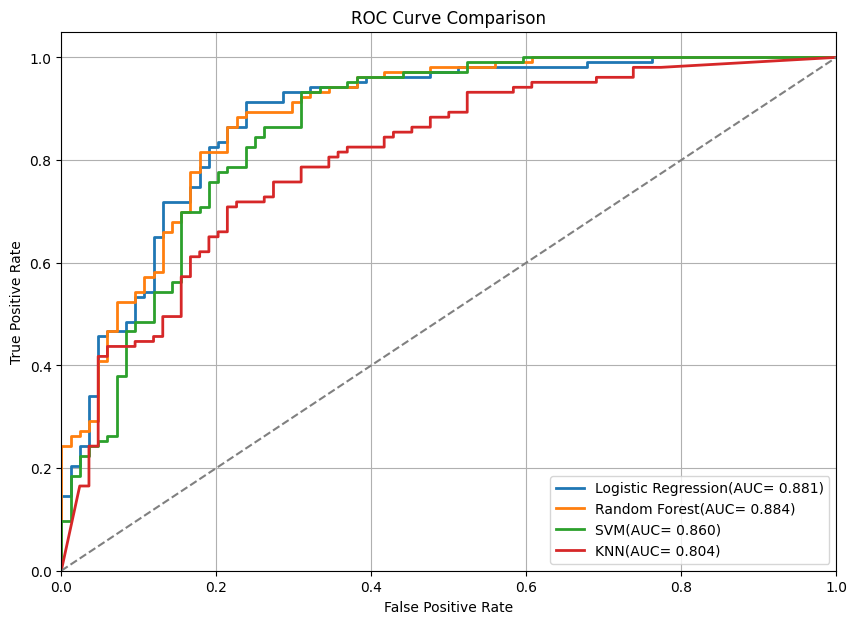

In [11]:
plt.figure(figsize=(10,7))
for name, probs in model_probs.items():
    fpr, tpr, _= roc_curve(y_test, probs)
    roc_auc=auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name}(AUC= {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [12]:
joblib.dump(best_rf, '../Models & Dataset/classification_model.pkl')

['../Models & Dataset/classification_model.pkl']